In [2]:
from urllib2 import Request, urlopen, HTTPError
from urlparse import urlunparse, urlparse
import json 
import pandas as pd
import requests
import requests_cache
from bs4 import BeautifulSoup

import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

### NYT Analysis

In [3]:
requests_cache.install_cache("project141")

In [4]:
def geturl(timeperiod):
    """
    Get the article urls within a time period in NYT
    Input:a time period
    Output: a list of all the articles' urls within the period.
    """
    url="https://api.nytimes.com/svc/mostpopular/v2/mostviewed/all-sections/"+str(timeperiod)+"/?api-key=YourKey"
    response=requests.get(url)
    urllist=[response.json()[u'results'][i][u'url'] for i in range(len(response.json()[u'results']))]
    return urllist

N_urllist=geturl(7)

In [6]:
def getcontent_NYT(url):
    """
    Extract text of an NYT article
    Input: url-> url for the article. 
    Output: a string of the text.      
    """
    artic= requests.get(url,"lxml")
    soup_arti=BeautifulSoup(artic.text)
    content=soup_arti.select("article[id='story'] > div[class='story-body-supplemental'] > div > p ")
    if content==[]:
        content=soup_arti.select("p[class='paragraph--story']")
    text=" ".join([i.text.strip() for i in content])
    return text

In [53]:
a=' '.join([getcontent_NYT(link) for link in N_urllist])                #join all the text in a string

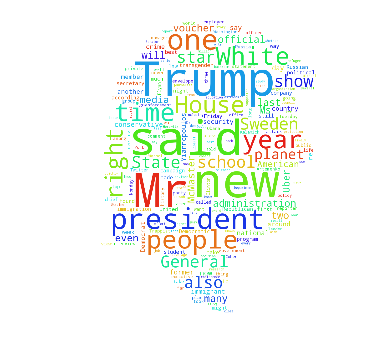

In [57]:
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from scipy.misc import imread

t1_mask = imread("trumpb.jpg")
#wordcloud = WordCloud().generate(a)
wordcloud = WordCloud(max_words=200, mask=t1_mask, background_color='white').generate(a)
# Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### the Guardian Analysis

In [32]:
requests_cache.install_cache("project141G")

In [34]:
def url_perpage(page,pagesize='50',fromdate='2017-02-22',todate='2017-02-28',form='json',order='oldest',key='YourKey'):
    """
    Get the urls for at most 50 articles from the Guardian in the last week of February
    Input: page number of the API content from which to extract the urls
    Output: a list of at most 50 urls.
    """
    url='https://content.guardianapis.com/search'
    response=requests.get(url,params={'page':page,'page-size':pagesize,'from-date':fromdate,'to-date':todate,'format':form,'order-by':order,'api-key':key})
    return [x['webUrl'] for x in response.json()['response']['results']]

urllist=[]
for page in range(1,37):
    urllist=urllist+url_perpage(page)

In [33]:
def getcontent_Guardian(url):
    """
    Extract text of a the Guardian article
    Input: url-> url for the article. 
    Output: a string of the text.       
    """
    artic= requests.get(url)
    soup=BeautifulSoup(artic.text)
    try:
        text=" ".join([i.text.strip() for i in soup.find_all('div',itemprop='articleBody')[0].find_all('p')])
        text=text.translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    except (IndexError,TypeError):
        text=''
    return text

In [14]:
a=' '.join([getcontent_Guardian(link) for link in urllist])                        #join all the text in a string

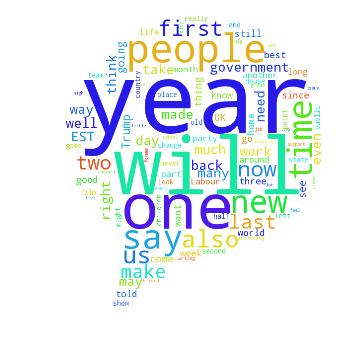

In [18]:
stopwords=set(STOPWORDS)
stopwords.add("said")

t1_mask = imread("111.jpg")
wordcloud = WordCloud(max_words=100, mask=t1_mask,stopwords=stopwords,background_color='white').generate(a)
# Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Similar articles

In [36]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize
def stem(tokens,stemmer = PorterStemmer().stem):
    """
    stemmatize words
    Input: words
    Output: stemmer
    """
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

In [8]:
NYT=pd.DataFrame()                                                   #convert all the NYT article texts into a dataframe
for link in N_urllist:
    NYT=NYT.append(pd.DataFrame({'text':[getcontent_NYT(link)]}),ignore_index=True)

In [35]:
Guardian=pd.DataFrame()                                              #convert all the Guardian article texts into a dataframe
for link in urllist:
    Guardian=Guardian.append(pd.DataFrame({'text':[getcontent_Guardian(link)]}),ignore_index=True)

In [37]:
total=Guardian.append(NYT,ignore_index=True)                         #merge the two dataframes together

__Then we get the most similar articles by similarity matrix__

In [24]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
A = vectorizer.fit_transform(total['text'])

In [25]:
P=A.toarray()
K=P.dot(P.T)
U=np.triu(K,k=1)

In [28]:
V=U[0:1783,1783:]

In [30]:
sort=np.sort(V,axis=None)
print np.where(V==sort[-1]), np.where(V==sort[-2]), np.where(V==sort[-3])

(array([30], dtype=int64), array([4], dtype=int64)) (array([30], dtype=int64), array([9], dtype=int64)) (array([1698], dtype=int64), array([4], dtype=int64))


__The two articles from NYT and The Guardian respectively are presented below:__

In [26]:
 getcontent_NYT(N_urllist[4])

u'I spent last week ignoring President Trump. Although I am ordinarily a politics junkie, I didn\u2019t read, watch or listen to a single story about anything having to do with our 45th president. What I missed, by many accounts, was one of the strangest and most unpredictable weeks of news in modern political history. Among other things, there was the resignation of the national security adviser, Michael T. Flynn, and an \u201cOprah Winfrey Show\u201d tape that led to the downfall of the nominee for secretary of labor, Andrew F. Puzder. It wasn\u2019t my aim to stick my head in the sand. I did not quit the news. Instead, I spent as much time as I normally do online (all my waking hours), but shifted most of my energy to looking for Trump-free zones. My point: I wanted to see what I could learn about the modern news media by looking at how thoroughly Mr. Trump had subsumed it. In one way, my experiment failed: I could find almost no Trump-free part of the press. But as the week wore on

In [27]:
getcontent_Guardian(urllist[30])

u'Now that political satire is dead, we must make some decisions about what will occupy the space in our lives it used to fill. You might just shrug and say "events". And while it\'s true that most mornings the radio news bulletin serves up as scabrous an indictment of politics as anything a writer could invent, it\'s not funny like Veep. Some weird synthesis of the real and the made-up \u2013 you can use the term "evention" if you promise not to credit me \u2013 may be the answer. But while you\'re waiting for it to come along, have a look the Twitter account @RoguePOTUSStaff. It purports to be leaking information from inside the White House, mostly more in sorrow than in anger: "POTUS was dismissive of PM May. \'I hope she\'ll like us, but she doesn\'t have much to offer\'." After less than a week, the account has approaching half a million followers. According to Twitter, this includes 57 people I follow \u2013 a thin but fairly representative cross section of the sneering liberal m